In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [2]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [3]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [4]:
# pneumonia
# blood_stream_infection
# abdominal_infection
# skin_and_soft_tissue_infection
# pneumonia

In [5]:
def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[design_matrix['verified_infection'] == 1]

    design_matrix = design_matrix[
        (design_matrix['urinary_tract_infection'] == 1) |
        #(design_matrix['blood_stream_infection'] == 1) |
        (design_matrix['abdominal_infection'] == 1) |
        (design_matrix['skin_and_soft_tissue_infection'] == 1) |
        (design_matrix['pneumonia'] == 1)
    ]

    design_matrix['group'] = np.where(
        design_matrix['pneumonia'] == 1, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [6]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )
    
    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]


    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix     


# Model Training

In [7]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

<Axes: xlabel='pneumonia', ylabel='Count'>

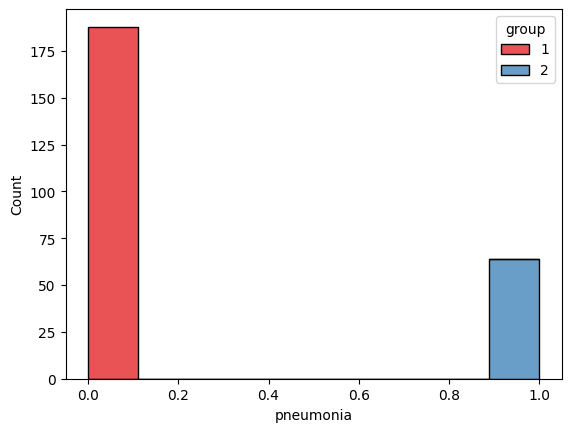

In [8]:
sns.histplot(
    design_matrix_train,
    x="pneumonia",
    hue="group",
    palette="Set1",
    multiple="stack"
)

In [9]:
design_matrix_train['group'].value_counts()

group
1    188
2     64
Name: count, dtype: int64

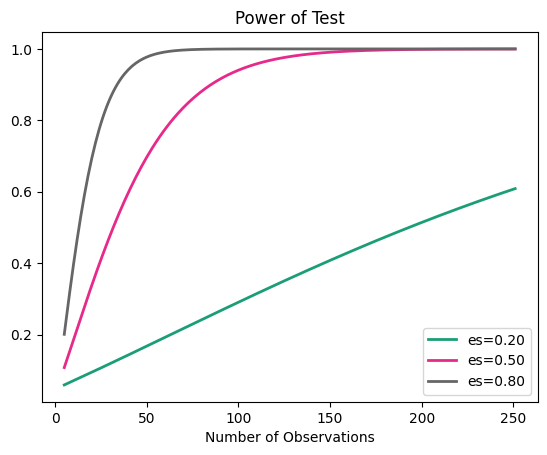

In [10]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [11]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [12]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [13]:
quant_matrix_train.write("de_results/lowerresp_de_proteins.tsv")

In [14]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

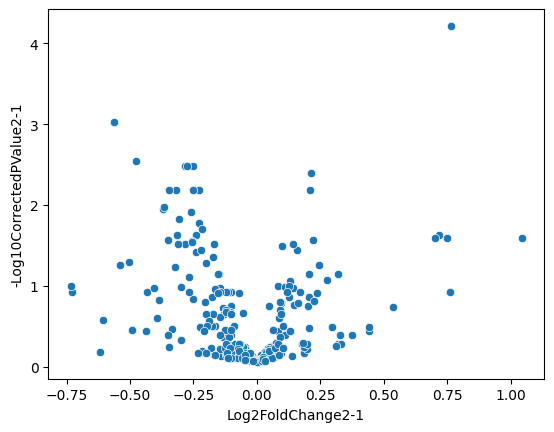

In [15]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [16]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [17]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [18]:
protein_columns = training_data.columns.to_list()

In [19]:
len(protein_columns)

287

In [20]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf
# )

In [22]:
y['label'].value_counts()

label
0    188
1     64
Name: count, dtype: int64

In [23]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 0.6702127659574468, 1: 1.96875}

In [24]:
# sample_weight = compute_sample_weight(
#     class_weight=class_weight,
#     y=y.values.ravel()
# )

In [25]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


In [26]:
selected_proteins

['FGL1_HUMAN',
 'QSOX1_HUMAN',
 'MBL2_HUMAN',
 'ITIH1_HUMAN',
 'CAMP_HUMAN',
 'PSPB_HUMAN',
 'ZPI_HUMAN',
 'C163A_HUMAN',
 'APOA4_HUMAN',
 'CO9_HUMAN',
 'FCN3_HUMAN',
 'APOH_HUMAN',
 'FCG3A_HUMAN',
 'HRG_HUMAN',
 'VASN_HUMAN',
 'COMP_HUMAN',
 'PCYOX_HUMAN',
 'A2AP_HUMAN',
 'APOC2_HUMAN',
 'CATB_HUMAN',
 'CETP_HUMAN',
 'ITIH2_HUMAN',
 'VWF_HUMAN',
 'AFAM_HUMAN',
 'ZA2G_HUMAN',
 'PZP_HUMAN',
 'FCN2_HUMAN',
 'LUM_HUMAN',
 'APOC1_HUMAN',
 'CSPG2_HUMAN',
 'LDHB_HUMAN',
 'CO6_HUMAN',
 'SAA1_HUMAN',
 'APOM_HUMAN',
 'CSF1R_HUMAN',
 'EIF3M_HUMAN',
 'PLSL_HUMAN',
 'SAA2_HUMAN',
 'PLTP_HUMAN',
 'APOB_HUMAN',
 'PGRP2_HUMAN',
 'CRIS3_HUMAN',
 'LG3BP_HUMAN',
 'APOC3_HUMAN',
 'IC1_HUMAN',
 'FIBB_HUMAN',
 'LKHA4_HUMAN',
 'TTHY_HUMAN',
 'CRP_HUMAN',
 'SODE_HUMAN']

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, HistGradientBoostingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [28]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.670995670995671, 0.5057471264367815, 0.75, 0.7237040140265947)

In [29]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [30]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [31]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [32]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
7,C163A_HUMAN,0.404173,13.0,0.613102,5.0,0.704735,5.0,0.469715,15.0,0.417186,...,1.000000,1.0,0.675463,7.0,0.647652,0.679341,0.279203,10.77,6.0,11.541629
5,PSPB_HUMAN,1.000000,1.0,1.000000,1.0,0.101135,44.0,0.629370,5.0,0.800234,...,0.317617,20.0,0.896700,2.0,0.563631,0.538620,0.290395,13.11,10.0,12.099666
6,ZPI_HUMAN,0.499970,9.0,0.291734,20.0,0.507247,19.0,0.994535,2.0,0.677120,...,0.821648,4.0,0.230877,26.0,0.530035,0.511742,0.276947,14.59,12.0,11.989132
39,APOB_HUMAN,0.813638,4.0,0.654318,4.0,0.752333,4.0,0.566116,10.0,0.929206,...,0.686516,6.0,0.280782,22.0,0.510047,0.506871,0.234938,14.44,10.0,11.424164
46,LKHA4_HUMAN,0.950594,2.0,0.213214,30.0,0.459219,20.0,0.615027,7.0,0.669691,...,0.497797,17.0,0.430294,13.0,0.497369,0.471690,0.271074,15.99,13.0,12.475831
3,ITIH1_HUMAN,0.158034,36.0,0.446769,10.0,0.147962,41.0,0.040819,49.0,0.461832,...,0.785287,5.0,1.000000,1.0,0.483126,0.462595,0.247166,15.98,12.0,12.550488
25,PZP_HUMAN,0.280475,25.0,0.553109,7.0,0.594519,10.0,0.145435,37.0,0.043612,...,0.880652,2.0,0.228833,28.0,0.467489,0.460461,0.233157,16.34,12.5,12.511990
12,FCG3A_HUMAN,0.276495,26.0,0.262931,24.0,0.566166,17.0,0.452540,18.0,0.464847,...,0.532586,12.0,0.527693,8.0,0.461474,0.434282,0.268711,17.58,15.5,12.319140
11,APOH_HUMAN,0.627882,6.0,0.243570,25.0,0.590879,13.0,0.114692,40.0,0.242424,...,0.573016,9.0,0.894012,3.0,0.457485,0.416308,0.296368,18.50,13.5,14.575821
13,HRG_HUMAN,0.268744,27.0,0.273411,22.0,0.292787,31.0,0.772980,3.0,0.711104,...,0.880421,3.0,0.683310,6.0,0.453376,0.434276,0.260124,18.21,15.0,13.729931


In [33]:
selected_proteins = protein_importances.head(10)['feature'].to_list()

In [34]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [35]:
selected_features = selected_proteins[:10]

In [36]:
for feature in selected_features:

    print(feature)

C163A_HUMAN
PSPB_HUMAN
ZPI_HUMAN
APOB_HUMAN
LKHA4_HUMAN
ITIH1_HUMAN
PZP_HUMAN
FCG3A_HUMAN
APOH_HUMAN
HRG_HUMAN


In [37]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [38]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, 
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.6724386724386724,
 0.49557913351016797,
 0.7420634920634921,
 0.7193051870471225)

In [39]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, 
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.5634920634920635,
 0.5686274509803922,
 0.7738095238095238,
 0.7045570916538658)

In [40]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
)

In [41]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [42]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [43]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
7,FCG3A_HUMAN,0.747733,4.0,0.630060,4.0,1.000000,1.0,0.889464,4.0,0.564090,...,0.637088,5.0,0.614166,4.0,0.740697,0.788920,0.265057,3.61,3.0,2.561940
1,PSPB_HUMAN,0.978768,2.0,1.000000,1.0,0.650000,2.0,0.940987,2.0,0.768461,...,0.248972,9.0,0.862072,2.0,0.730104,0.749832,0.212829,3.64,3.0,2.105884
2,ZPI_HUMAN,0.692791,5.0,0.421227,5.0,0.329291,7.0,0.859521,6.0,0.529438,...,0.726508,3.0,0.658838,3.0,0.686923,0.694677,0.218682,4.21,4.0,2.323768
5,ITIH1_HUMAN,0.608759,7.0,0.255989,9.0,0.023391,10.0,0.890059,3.0,1.000000,...,1.000000,1.0,0.556124,5.0,0.671392,0.720834,0.261076,4.37,4.0,2.676705
0,C163A_HUMAN,0.459262,9.0,0.298211,8.0,0.163477,8.0,1.000000,1.0,0.568779,...,0.806063,2.0,1.000000,1.0,0.617510,0.637838,0.277060,5.10,5.0,2.879745
4,LKHA4_HUMAN,0.772673,3.0,0.708154,3.0,0.354119,6.0,0.888273,5.0,0.658328,...,0.646392,4.0,0.256797,9.0,0.555853,0.580654,0.256062,5.52,5.0,2.587772
8,APOH_HUMAN,1.000000,1.0,0.861687,2.0,0.530669,4.0,0.037957,10.0,0.348260,...,0.332798,7.0,0.398528,6.0,0.452377,0.398749,0.258740,6.54,7.0,2.679590
6,PZP_HUMAN,0.607590,8.0,0.392061,7.0,0.482247,5.0,0.486611,8.0,0.192548,...,0.580052,6.0,0.368590,8.0,0.448229,0.464394,0.220121,6.80,7.0,2.278578
3,APOB_HUMAN,0.625006,6.0,0.398335,6.0,0.618237,3.0,0.341305,9.0,0.706095,...,0.158322,10.0,0.169607,10.0,0.442149,0.413199,0.234613,6.88,7.0,2.559514
9,HRG_HUMAN,0.001213,10.0,0.065954,10.0,0.123394,9.0,0.556775,7.0,0.311326,...,0.290514,8.0,0.376480,7.0,0.306854,0.297614,0.190325,8.33,9.0,1.676064


In [44]:
final_protein_importances.to_csv(
    "feature_importances/lowerresp_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [45]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [46]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [47]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [48]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [49]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [50]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [51]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

decision_tree = DecisionTreeClassifier(random_state=42)

random_forest = RandomForestClassifier(random_state=42)

svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)



# lr_clf = GradientBoostingClassifier(
#     #estimator=random_forest,
#     random_state=42
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)




In [52]:
lr_clf.fit(X[selected_features], y.values.ravel(), )
xgb_clf.fit(X[selected_features], y.values.ravel(), )
decision_tree.fit(X[selected_features], y.values.ravel(), ) 
random_forest.fit(X[selected_features], y.values.ravel(), )
svc.fit(X[selected_features], y.values.ravel(), )
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), ) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [53]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [54]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.5576923076923077,
 0.5426356589147286,
 0.41830065359477125,
 0.4482758620689655,
 0.5299145299145299,
 0.5238095238095238,
 0.6027397260273972,
 0.6052631578947368)

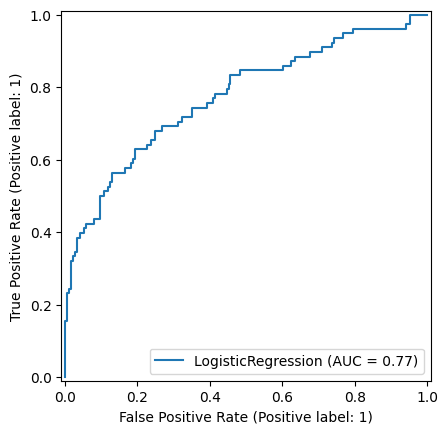

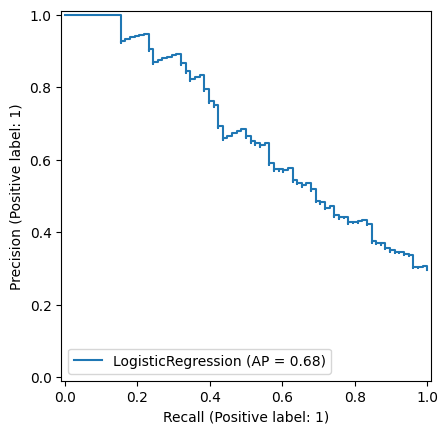

In [55]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [56]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [57]:
roc_df.to_csv(
    "roc/lowerresp.tsv",
    sep="\t"
)

# Probability Prediction

In [58]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
).impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [59]:
predict_data = predict_data[protein_columns].copy()

In [60]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [61]:
predict_data['lowerresp_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [62]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['lowerresp_probability']
).reset_index()

In [63]:
predict_data[['lowerresp_probability']].to_csv(
    "predictions_test/lowerresp.tsv",
    sep="\t"
)

<Axes: xlabel='lowerresp_probability', ylabel='Count'>

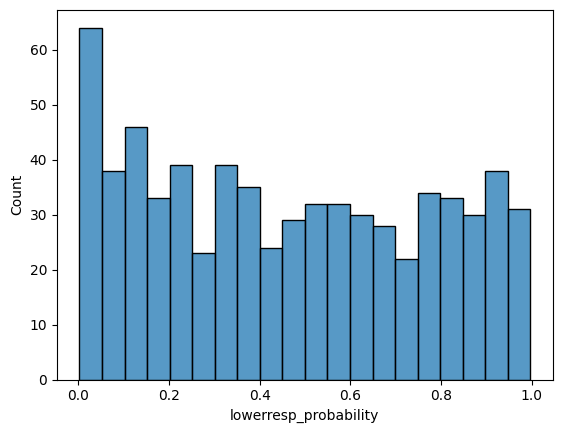

In [64]:
sns.histplot(
    data=design_matrix_test,
    x="lowerresp_probability",
    #hue="sofa_lowerresp_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [65]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [66]:
val_data = val_data[protein_columns].copy()

In [67]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [68]:
val_data['lowerresp_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [69]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['lowerresp_probability']
).reset_index()

In [70]:
val_data[['lowerresp_probability']].to_csv(
    "predictions_val/lowerresp.tsv",
    sep="\t"
)

<Axes: xlabel='lowerresp_probability', ylabel='Count'>

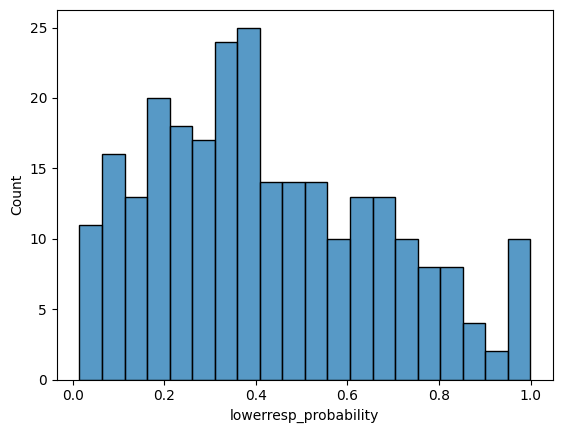

In [71]:
sns.histplot(
    data=design_matrix_val,
    x="lowerresp_probability",
    #hue="sofa_lowerresp_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [72]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [73]:
hero_data = hero_data[protein_columns].copy()

In [74]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [75]:
hero_data['lowerresp_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [76]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['lowerresp_probability']
).reset_index()

In [77]:
hero_data[['lowerresp_probability']].to_csv(
    "predictions_external/lowerresp.tsv",
    sep="\t"
)

<Axes: xlabel='lowerresp_probability', ylabel='Count'>

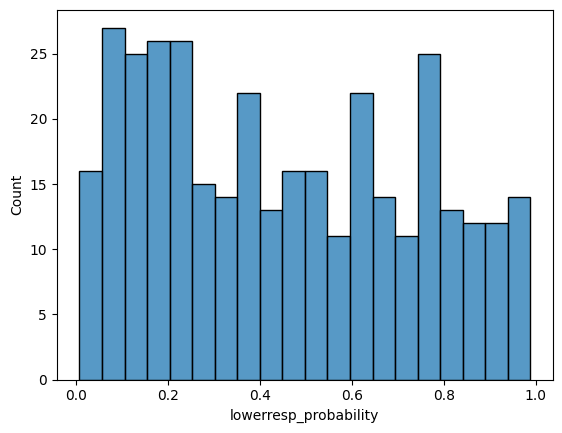

In [78]:
sns.histplot(
    data=hero_data,
    x="lowerresp_probability",
    #hue="sofa_lowerresp_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [79]:
from joblib import dump


with open("models/lowerresp_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/lowerresp_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
